In [2]:
# Loading text Images

In [47]:
import matplotlib.pyplot as plt
import cv2
import os, glob
import numpy as np
%matplotlib inline

In [48]:
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

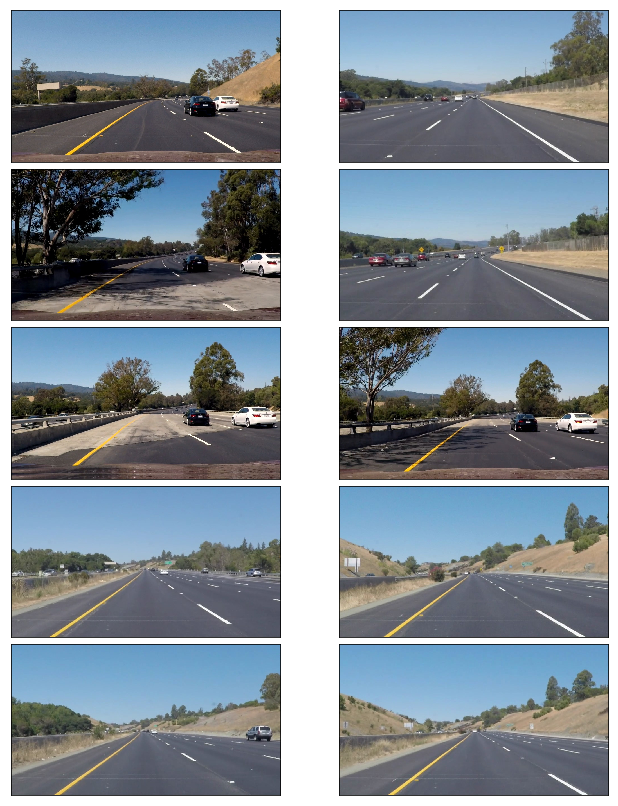

In [49]:
test_images=[plt.imread(path)  for path in glob.glob('test_images/*.jpg')]
show_images(test_images)

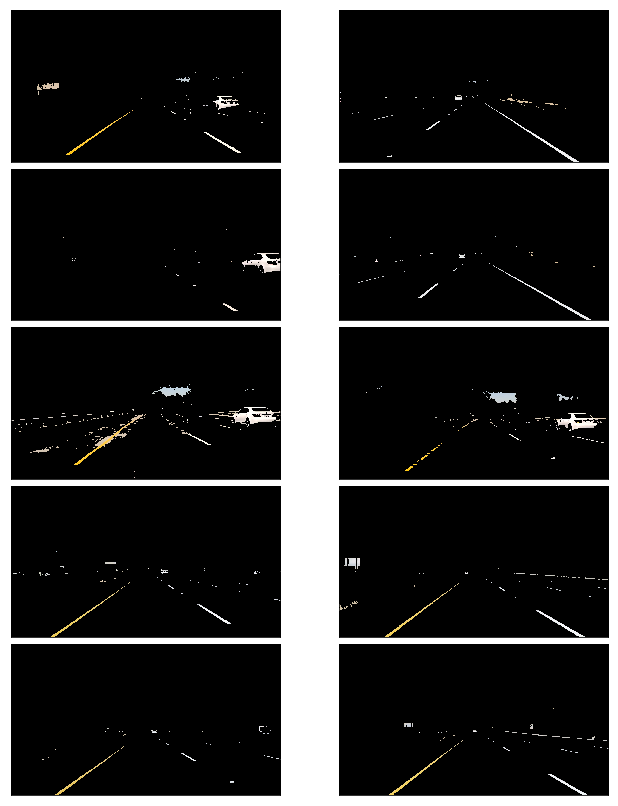

In [50]:
def extract_yellow_white(image):
    #white mask
    low=np.uint8([200,200,200])
    high=np.uint8([255,255,255])
    white_mask=cv2.inRange(image,low,high)
    #high mask
    low=np.uint8([190,190,0])
    high=np.uint8([255,255,255])
    yellow_mask=cv2.inRange(image,low,high)
    
    mask=cv2.bitwise_or(white_mask,yellow_mask)
    masked=cv2.bitwise_and(image,image,mask=mask)
    return masked

white_yellow=list(map(extract_yellow_white, test_images))
show_images(white_yellow)
    
    
    

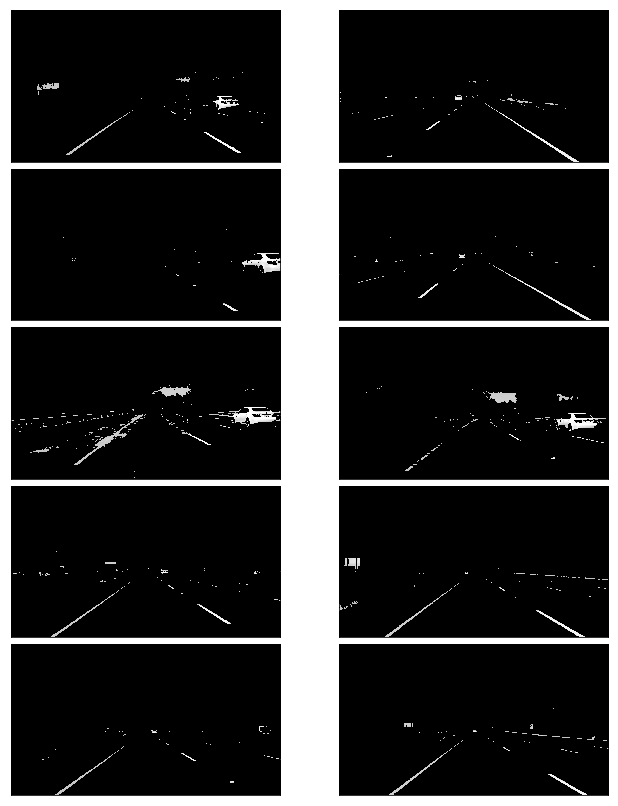

In [51]:
def gray_scale(img):
    return cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

gray_images=list(map(gray_scale,white_yellow))
show_images(gray_images)

In [52]:
def apply_smoothing(image, kernel_size=11):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

In [53]:
blurred_images = list(map(lambda image: apply_smoothing(image), gray_images))

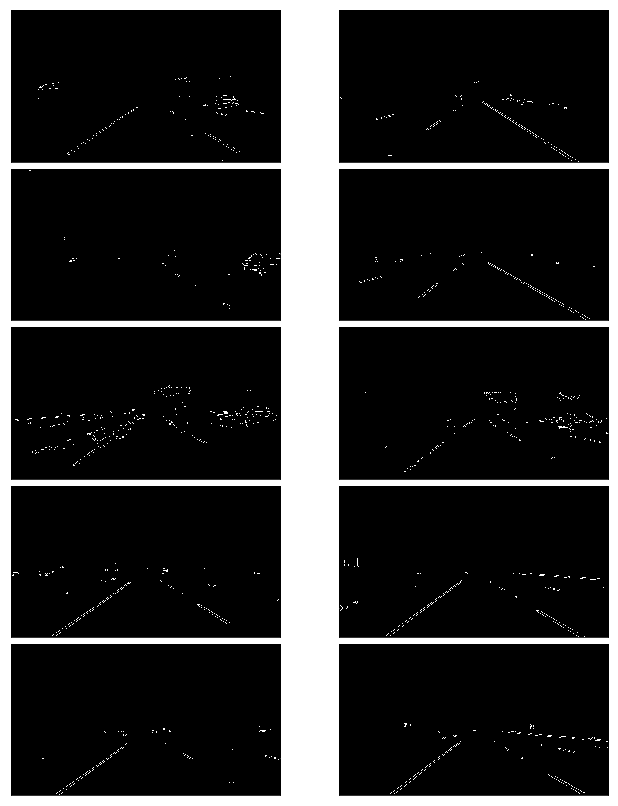

In [54]:
def detect_edges(image, low_threshold=50, high_threshold=150):
    return cv2.Canny(image, low_threshold, high_threshold)
edge_images = list(map(lambda image: detect_edges(image), blurred_images))
show_images(edge_images)

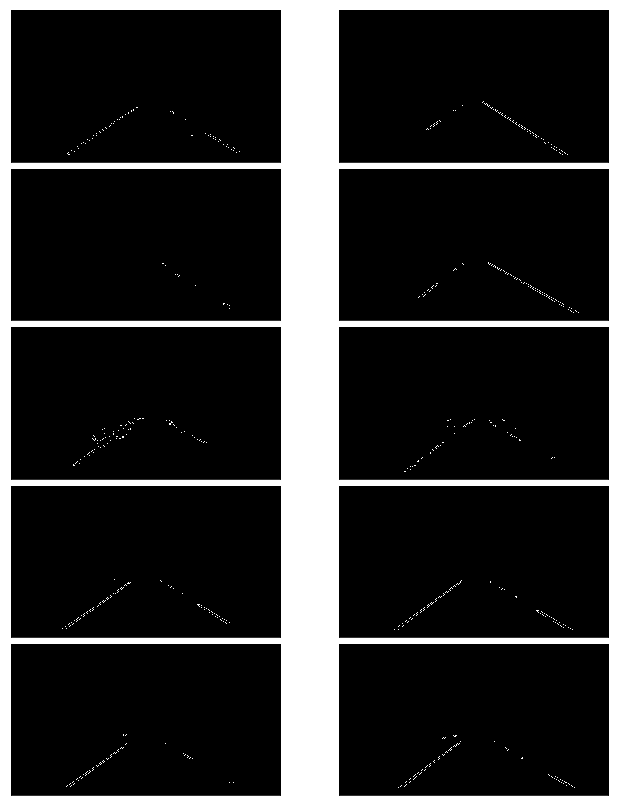

In [55]:
def filter_region(image, vertices):
    mask = np.zeros_like(image)
    if len(mask.shape)==2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255,)*mask.shape[2])         
    return cv2.bitwise_and(image, mask)

    
def select_region(image):
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.1, rows*0.95]
    top_left     = [cols*0.4, rows*0.6]
    bottom_right = [cols*0.9, rows*0.95]
    top_right    = [cols*0.6, rows*0.6] 
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return filter_region(image, vertices)

roi_images = list(map(select_region, edge_images))

show_images(roi_images)

In [56]:
def hough_lines(image):
    return cv2.HoughLinesP(image, rho=1, theta=np.pi/180, threshold=20, minLineLength=20, maxLineGap=300)

list_of_lines = list(map(hough_lines, roi_images))

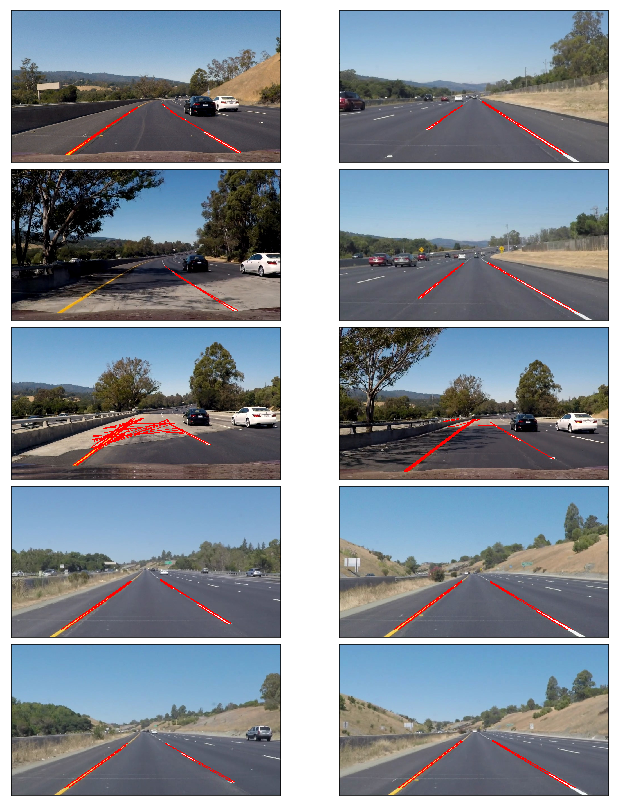

In [57]:
def draw_lines(image, lines, color=[255, 0, 0], thickness=2, make_copy=True):
   
    if make_copy:
        image = np.copy(image) 
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image


line_images = []
for image, lines in zip(test_images, list_of_lines):
    line_images.append(draw_lines(image, lines))
    
show_images(line_images)